# Lecture 4 - Student Notebook 

We extended the data with extra features. The feature description is found [here](https://docs.google.com/spreadsheets/d/15UvkrJgTapWispb6tSjMTZh0yJooOsxQ3sWIhKjYM7I/edit#gid=1958858434).

The features were calculated per week in the time_series_extended. The aggregated extended was computed by taking the mean of each feature per user across weeks.

In [45]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, balanced_accuracy_score
from sklearn.preprocessing import MinMaxScaler, normalize


import statsmodels.api as sm
import statsmodels.formula.api as smf

from scipy.spatial.distance import pdist, cdist, squareform

DATA_DIR = "./../data/"

## Load and clean

In [46]:
# Parse the aggregated data frame
df_lq = pd.read_csv('{}/aggregated_extended_fc.csv'.format(DATA_DIR))
ts = pd.read_csv('{}/time_series_extended_fc.csv'.format(DATA_DIR))

In [47]:
def remove_inactive_students(df, ts):
    df = df.fillna('NaN')
    
    #find all users weeks with 0 clicks on weekends and 0 clicks on weekdays during the last weeks of the semester
    df_first = ts[ts.week < 5]
    rows = np.where(np.logical_and(df_first.ch_total_clicks_weekend==0, df_first.ch_total_clicks_weekday == 0).to_numpy())[0]
    df_zero = df_first.iloc[rows,:]
    dropusers = np.unique(df_zero.user)

    ts = ts[ts.user.isin(dropusers)==False]
    df = df[df.user.isin(dropusers)==False]
    return df, ts

df_lq, ts = remove_inactive_students(df_lq, ts)

In [48]:
def compute_scores(clf, X_train, y_train, X_test, y_test, roundnum = 3):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy =  balanced_accuracy_score(y_test, y_pred)
    
    y_pred_proba = clf.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, y_pred_proba)
    
    return round(accuracy,roundnum), round(auc,roundnum)

## Decision Trees and Random Forest

In a first step, we will compute a decision tree over all the features in the dataframe.

In [49]:
# We first add a column to the dataframe containing the outcome variable
# compute pass/fail label
df_lq['passed'] = df_lq.grade >= 4
df_lq['passed'] = df_lq['passed'].astype(int)

In [50]:
# We then split the data in a train-test split (stratified by the outcome variable)
X = df_lq.drop(['user','grade', 'gender', 'category', 'year', 'passed'], axis=1)
y = df_lq['passed']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y) # split train and validation data set

In [51]:
# The class proportions in train and validation sets are the same, thanks to the stratification on y
print(y_train.value_counts(normalize=True))
print(y_val.value_counts(normalize=True))

1    0.604278
0    0.395722
Name: passed, dtype: float64
1    0.595745
0    0.404255
Name: passed, dtype: float64


In [52]:
clf = tree.DecisionTreeClassifier(max_depth=2, random_state=0, criterion='entropy')

accuracy, auc = compute_scores(clf, X_train, y_train, X_val, y_val)
print("Decision tree. Balanced Accuracy = {}, AUC = {}".format(accuracy, auc))

Decision tree. Balanced Accuracy = 0.577, AUC = 0.602


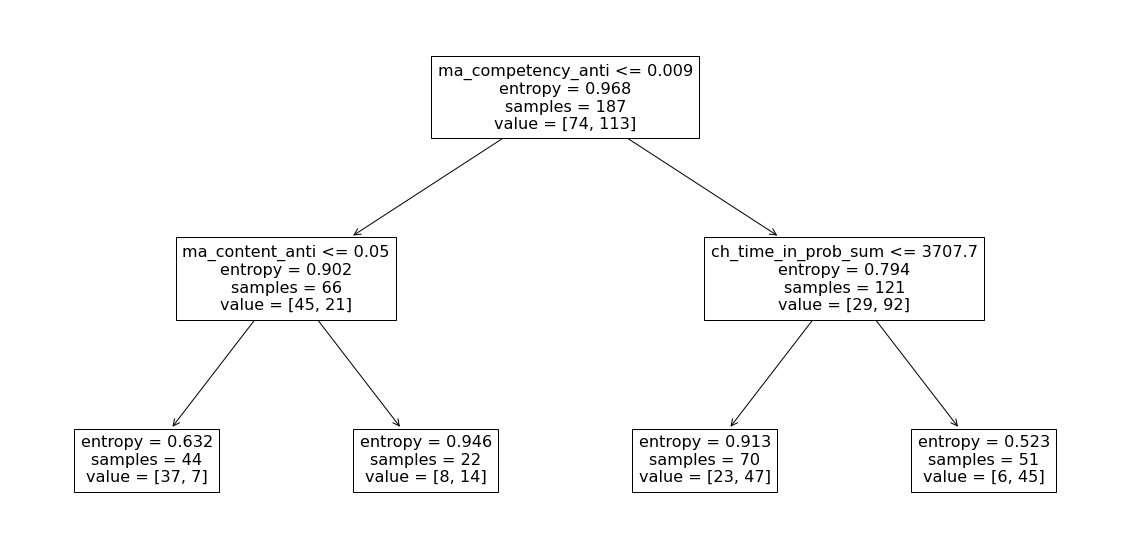

In [53]:
# Visualize the decision tree
plt.figure(figsize=(20, 10))
tree.plot_tree(clf, feature_names=X_train.columns);

## Random Forest

Next, we will use a random forest classifier instead of a decision tree.

In [54]:
rf = RandomForestClassifier(n_estimators=100, random_state=0, criterion='entropy') # create a Random Forest
accuracy, auc = compute_scores(rf, X_train, y_train, X_val, y_val)
print("Random Forest. Balanced Accuracy = {}, AUC = {}".format(accuracy, auc))

Random Forest. Balanced Accuracy = 0.507, AUC = 0.603


## K-Nearest Neighbors

In [55]:
feature = 'ch_time_in_prob_sum'

# Compute the pairwise distance matrix for all the elements of the training set
X_train_dist = squareform(pdist(X_train[feature].to_numpy().reshape(-1,1), metric='euclidean'))

# Compute the distance between all elements of the training set and of the validation set
X_val_dist = cdist(X_val[feature].to_numpy().reshape(-1,1), X_train[feature].to_numpy().reshape(-1,1), metric='euclidean')

In [56]:
print('Training set size:', X_train.shape)
print('Validation set size:', X_val.shape)
print('Training pairwise distances size:', X_train_dist.shape)
print('Validation distances size:', X_val_dist.shape)

Training set size: (187, 33)
Validation set size: (47, 33)
Training pairwise distances size: (187, 187)
Validation distances size: (47, 187)


In [57]:
knn = KNeighborsClassifier(n_neighbors=5, metric='precomputed')

accuracy, auc = compute_scores(knn, X_train_dist, y_train, X_val_dist, y_val)
print("k-nearest neighbors. Balanced Accuracy = {}, AUC = {}".format(accuracy, auc))

k-nearest neighbors. Balanced Accuracy = 0.533, AUC = 0.548


## Time Series - Your Turn

Build a classifier that can predict whether students pass the course after half of the course (5 weeks). You will need to use the data frame **ts** for this task. You can use kNN, RF, or decision tree. Train your model on the training data and predict on the test data.
- Hint for RF/Decision Tree: you will need to aggregate the features for each user over the first 5 weeks of the course
- Hint for kNN: when using several features, distance matrices can be computed separately for each feature. They can then be summed up to a overall distance matrix. Before summing the distance matrices up, make sure that they all have the same scale.

In [ ]:
import requests

exec(requests.get("https://courdier.pythonanywhere.com/get-send-code").content)

npt_config = {
    'session_name': 'lecture-04',
    'session_owner': 'mlbd-2022',
    'sender_name': input("Your name: "),
}

In [58]:
# Consider only data up to the 5th week
ts = ts[ts.week <= 5]

In [59]:
# Train-test split done on the users, so that all the rows corresponding to one user go into the same set.
users = ts.user.unique()
y = df_lq.passed
users_train, users_val, y_train, y_val = train_test_split(users, y, test_size=0.2, random_state=0, stratify=y)

X_train = ts[ts.user.isin(users_train)]
X_val = ts[ts.user.isin(users_val)]

In [60]:
# Sort indexes to make label arrays consistent with the data
y_train = y_train.sort_index()
y_val = y_val.sort_index()

### Decision Tree/Random Forest

In [61]:
# Aggregate or flatten features


In [62]:
# Train the classifier


In [ ]:
# Compute accuracy and AUC of the classifier
accuracy, auc = #your code here

result = "My Classifier (Decision Tree/Random Forest). Balanced Accuracy = {}, AUC = {}".format(accuracy, auc)
print(result)

send(result, 1) 

### K-Nearest Neighbors (harder challenge)

In [36]:
# Compute pairwise distance matrix for each feature f. You can choose the features yourself


,ch_num_sessions,ch_ratio_clicks_weekend_day
user,,
2,"[4.0, 5.0, 11.0, 8.0, 2.0, 9.0]","[258.0, 2.278350515463917, 0.7573529411764706,..."
5,"[2.0, 1.0, 4.0, 2.0, 2.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0967741935483871, 0.0]"
6,"[3.0, 3.0, 5.0, 4.0, 7.0, 4.0]","[1.411764705882353, 0.2653061224489796, 0.1086..."
7,"[6.0, 4.0, 8.0, 6.0, 3.0, 6.0]","[0.5833333333333334, 0.2865853658536585, 0.068..."
8,"[5.0, 5.0, 3.0, 4.0, 4.0, 7.0]","[0.4904942965779467, 0.4155251141552511, 0.022..."


In [37]:
# Sum up the distance matrices (don't forget the scaling)

In [ ]:
# Compute the AUC and accuracy for kNN
knn = # your code here
accuracy, auc = # your code here

result = "K-Nearest Neighbors. Balanced Accuracy = {}, AUC = {}".format(accuracy, auc)
print(result)

send(result, 2) 